In [1]:
# Try to decode which feature was selected per-trial based on firing rates of neurons
# experiment with ranges of firing rates around fixation (selection) time

%load_ext autoreload
%autoreload 2

import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import matplotlib.patches as patches

import pandas as pd
import scipy.stats
from lfp_tools import (
    general as lfp_general,
    startup as lfp_startup,
    development as lfp_development,
    analysis as lfp_analysis
)
from spike_tools import (
    general as spike_general,
    analysis as spike_analysis,
)
import s3fs
import utils.behavioral_utils as behavioral_utils
import utils.spike_utils as spike_utils
import utils.classifier_utils as classifier_utils
import utils.visualization_utils as visualization_utils
import utils.io_utils as io_utils
from trial_splitters.random_splitter import RandomSplitter
from trial_splitters.block_splitter import BlockSplitter
from models.model_wrapper import ModelWrapper
from models.multinomial_logistic_regressor import MultinomialLogisticRegressor, NormedMultinomialLogisticRegressor
from models.multi_layer import MultiLayer

from models.trainer import Trainer
import pickle

from sklearn.cluster import KMeans
import plotly.express as px
from itertools import accumulate

import torch

matplotlib.rcParams['figure.dpi'] = 150


### Grab Data

In [2]:
species = 'nhp'
subject = 'SA'
exp = 'WCST'
session = 20180802  # this is the session for which there are spikes at the moment. 
pre_interval = 1300
post_interval = 2000

feature_dims = ["Color", "Shape", "Pattern"]

In [3]:
# grab behavioral data, spike data, trial numbers. 
fs = s3fs.S3FileSystem()
behavior_file = spike_general.get_behavior_path(subject, session)
behavior_data = pd.read_csv(fs.open(behavior_file))
valid_beh = behavior_data[behavior_data.Response.isin(["Correct", "Incorrect"])]   
valid_beh = valid_beh[valid_beh.TrialNumber >= 57]

In [4]:
firing_rates = pd.read_pickle(fs.open(f"l2l.pqz317.scratch/firing_rates_{pre_interval}_fb_{post_interval}_100_bins.pickle"))
firing_rates = firing_rates[firing_rates.TrialNumber >= 57]

### Label trials as explore/exploit

In [5]:
response_codes = [200 if res == "Correct" else 206 for res in valid_beh.Response.values]

In [13]:
explore_exploit = lfp_development.get_exploration(np.array(response_codes), 2)
valid_beh["explore"] = explore_exploit

In [14]:
explore_trials = valid_beh[valid_beh.explore == 1]
exploit_trials = valid_beh[valid_beh.explore == 0]

print(f"Number of correct trials in explore state: {len(explore_trials[explore_trials.Response == 'Correct'])}")
print(f"Number of incorrect trials in explore state: {len(explore_trials[explore_trials.Response == 'Incorrect'])}")
print(f"Number of correct trials in exploit state: {len(exploit_trials[exploit_trials.Response == 'Correct'])}")
print(f"Number of incorrect trials in exploit state: {len(exploit_trials[exploit_trials.Response == 'Incorrect'])}")


Number of correct trials in explore state: 327
Number of incorrect trials in explore state: 422
Number of correct trials in exploit state: 619
Number of incorrect trials in exploit state: 324


### Subsample to balance groups out

In [15]:
rng = np.random.default_rng(seed=42)
num_samples = 285 # smallest common number
explore_cor_sampled = explore_trials[explore_trials.Response == 'Correct'].sample(num_samples, random_state=rng)
explore_inc_sampled = explore_trials[explore_trials.Response == 'Incorrect'].sample(num_samples, random_state=rng)
exploit_cor_sampled = exploit_trials[exploit_trials.Response == 'Correct'].sample(num_samples, random_state=rng)
exploit_inc_sampled = exploit_trials[exploit_trials.Response == 'Incorrect'].sample(num_samples, random_state=rng)


In [16]:
explore_bal = pd.concat([explore_cor_sampled, explore_inc_sampled]).sort_values(by="TrialNumber")
exploit_bal = pd.concat([exploit_cor_sampled, exploit_inc_sampled]).sort_values(by="TrialNumber")

explore_firing_rates = firing_rates[firing_rates.TrialNumber.isin(explore_bal.TrialNumber)]
exploit_firing_rates = firing_rates[firing_rates.TrialNumber.isin(exploit_bal.TrialNumber)]


### Now look at Feedback decodability of two groups

#### Explore

In [17]:

num_neurons = len(explore_firing_rates.UnitID.unique())
classes = explore_bal.Response.unique()
init_params = {"n_inputs": num_neurons, "n_classes": len(classes)}
trainer = Trainer(learning_rate=0.01)
wrapped = ModelWrapper(NormedMultinomialLogisticRegressor, init_params, trainer, classes)

mode = "SpikeCounts"

# prep data for classification
inputs = explore_firing_rates.rename(columns={mode: "Value"})
labels = explore_bal[["TrialNumber", "Response"]].rename(columns={"Response": "Feature"})

random_splitter = RandomSplitter(labels.TrialNumber.unique(), 20, 0.2)

_, test_accs_by_bin, shuffled_accs, models, splits = classifier_utils.evaluate_classifiers_by_time_bins(
    wrapped, inputs, labels, np.arange(0, 3.3, 0.1), random_splitter
)

np.save(fs.open(f"l2l.pqz317.scratch/explore_fb_accs_{pre_interval}_fb_{post_interval}_by_bin_random_split.npy", "wb"), test_accs_by_bin)
np.save(fs.open(f"l2l.pqz317.scratch/explore_fb_shuffled_accs_{pre_interval}_fb_{post_interval}_by_bin_random_split.npy", "wb"), shuffled_accs)
np.save(fs.open(f"l2l.pqz317.scratch/explore_fb_models_{pre_interval}_fb_{post_interval}_by_bin_random_split.npy", "wb"), models)
pickle.dump(splits, fs.open(f"l2l.pqz317.scratch/explore_fb_splits_{pre_interval}_fb_{post_interval}_by_bin_random_split.npy", "wb"))

Evaluating for bin 0.0
Evaluating for bin 0.1
Evaluating for bin 0.2
Evaluating for bin 0.30000000000000004
Evaluating for bin 0.4
Evaluating for bin 0.5
Evaluating for bin 0.6000000000000001
Evaluating for bin 0.7000000000000001
Evaluating for bin 0.8
Evaluating for bin 0.9
Evaluating for bin 1.0
Evaluating for bin 1.1
Evaluating for bin 1.2000000000000002
Evaluating for bin 1.3
Evaluating for bin 1.4000000000000001
Evaluating for bin 1.5
Evaluating for bin 1.6
Evaluating for bin 1.7000000000000002
Evaluating for bin 1.8
Evaluating for bin 1.9000000000000001
Evaluating for bin 2.0
Evaluating for bin 2.1
Evaluating for bin 2.2
Evaluating for bin 2.3000000000000003
Evaluating for bin 2.4000000000000004
Evaluating for bin 2.5
Evaluating for bin 2.6
Evaluating for bin 2.7
Evaluating for bin 2.8000000000000003
Evaluating for bin 2.9000000000000004
Evaluating for bin 3.0
Evaluating for bin 3.1
Evaluating for bin 3.2


#### Exploit

In [18]:

num_neurons = len(exploit_firing_rates.UnitID.unique())
classes = exploit_bal.Response.unique()
init_params = {"n_inputs": num_neurons, "n_classes": len(classes)}
trainer = Trainer(learning_rate=0.01)
wrapped = ModelWrapper(NormedMultinomialLogisticRegressor, init_params, trainer, classes)

mode = "SpikeCounts"

# prep data for classification
inputs = exploit_firing_rates.rename(columns={mode: "Value"})
labels = exploit_bal[["TrialNumber", "Response"]].rename(columns={"Response": "Feature"})

random_splitter = RandomSplitter(labels.TrialNumber.unique(), 20, 0.2)

_, test_accs_by_bin, shuffled_accs, models, splits = classifier_utils.evaluate_classifiers_by_time_bins(
    wrapped, inputs, labels, np.arange(0, 3.3, 0.1), random_splitter
)

np.save(fs.open(f"l2l.pqz317.scratch/exploit_fb_accs_{pre_interval}_fb_{post_interval}_by_bin_random_split.npy", "wb"), test_accs_by_bin)
np.save(fs.open(f"l2l.pqz317.scratch/exploit_fb_shuffled_accs_{pre_interval}_fb_{post_interval}_by_bin_random_split.npy", "wb"), shuffled_accs)
np.save(fs.open(f"l2l.pqz317.scratch/exploit_fb_models_{pre_interval}_fb_{post_interval}_by_bin_random_split.npy", "wb"), models)
pickle.dump(splits, fs.open(f"l2l.pqz317.scratch/exploit_fb_splits_{pre_interval}_fb_{post_interval}_by_bin_random_split.npy", "wb"))

Evaluating for bin 0.0
Evaluating for bin 0.1
Evaluating for bin 0.2
Evaluating for bin 0.30000000000000004
Evaluating for bin 0.4
Evaluating for bin 0.5
Evaluating for bin 0.6000000000000001
Evaluating for bin 0.7000000000000001
Evaluating for bin 0.8
Evaluating for bin 0.9
Evaluating for bin 1.0
Evaluating for bin 1.1
Evaluating for bin 1.2000000000000002
Evaluating for bin 1.3
Evaluating for bin 1.4000000000000001
Evaluating for bin 1.5
Evaluating for bin 1.6
Evaluating for bin 1.7000000000000002
Evaluating for bin 1.8
Evaluating for bin 1.9000000000000001
Evaluating for bin 2.0
Evaluating for bin 2.1
Evaluating for bin 2.2
Evaluating for bin 2.3000000000000003
Evaluating for bin 2.4000000000000004
Evaluating for bin 2.5
Evaluating for bin 2.6
Evaluating for bin 2.7
Evaluating for bin 2.8000000000000003
Evaluating for bin 2.9000000000000004
Evaluating for bin 3.0
Evaluating for bin 3.1
Evaluating for bin 3.2


#### Visualize

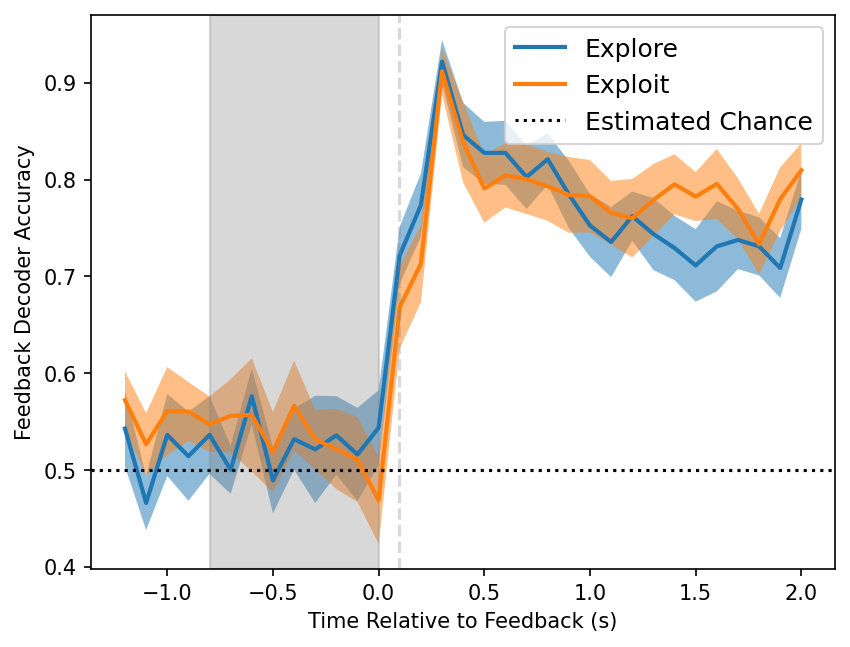

In [19]:
test_explore_accs_by_bin = np.load(fs.open(f"l2l.pqz317.scratch/explore_fb_accs_{pre_interval}_fb_{post_interval}_by_bin_random_split.npy", "rb"))
test_exploit_accs_by_bin = np.load(fs.open(f"l2l.pqz317.scratch/exploit_fb_accs_{pre_interval}_fb_{post_interval}_by_bin_random_split.npy", "rb"))

fig, ax = plt.subplots()

visualization_utils.visualize_accuracy_across_time_bins(
    test_explore_accs_by_bin,
    1.3, 2, .1,
    ax,
    label="Explore",
    right_align=True
)
visualization_utils.visualize_accuracy_across_time_bins(
    test_exploit_accs_by_bin,
    1.3, 2, .1,    
    ax,
    label="Exploit",
    right_align=True
)
ax.axvspan(-0.8, 0, alpha=0.3, color='gray')
ax.axvline(0.098, alpha=0.3, color='gray', linestyle='dashed')
ax.axhline(0.5, color='black', linestyle='dotted', label="Estimated Chance")
ax.set_xlabel("Time Relative to Feedback (s)")
ax.set_ylabel("Feedback Decoder Accuracy")
# ax.set_title(f"Decoding Choice with 100ms Bins of Spiking")
ax.legend(prop={'size': 12})
# fig.savefig(fs.open("l2l.pqz317.scratch/figs/value_normed_model.pdf", "wb"))
# fig.savefig("../data/value_normed_model.pdf")
# fig.show()


### Now look at cross decodability

In [13]:
explore_models = np.load(fs.open(f"l2l.pqz317.scratch/explore_fb_models_{pre_interval}_fb_{post_interval}_by_bin_random_split.npy", "rb"), allow_pickle=True)
exploit_models = np.load(fs.open(f"l2l.pqz317.scratch/exploit_fb_models_{pre_interval}_fb_{post_interval}_by_bin_random_split.npy", "rb"), allow_pickle=True)

mode = "SpikeCounts"

# prep data for classification
explore_inputs = explore_firing_rates.rename(columns={mode: "Value"})
explore_labels = explore_bal[["TrialNumber", "Response"]].rename(columns={"Response": "Feature"})

exploit_inputs = exploit_firing_rates.rename(columns={mode: "Value"})
exploit_labels = exploit_bal[["TrialNumber", "Response"]].rename(columns={"Response": "Feature"})
bins = np.arange(0, 3.3, 0.1)

explore_on_exploit_accs = classifier_utils.evaluate_models_by_time_bins(explore_models, exploit_inputs, exploit_labels, bins)
exploit_on_explore_accs = classifier_utils.evaluate_models_by_time_bins(exploit_models, explore_inputs, explore_labels, bins)

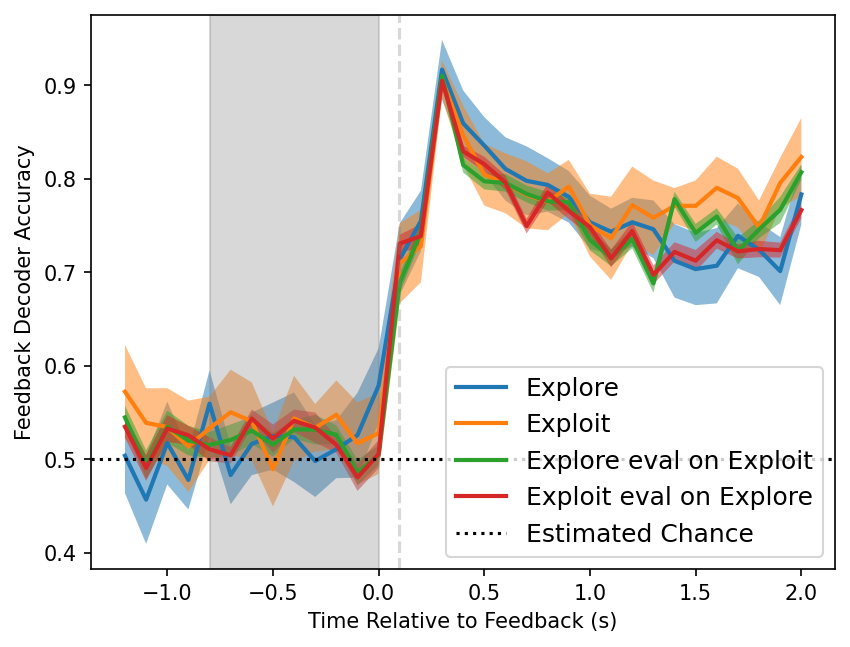

In [14]:
fig, ax = plt.subplots()
visualization_utils.visualize_accuracy_across_time_bins(
    test_explore_accs_by_bin,
    1.3, 2, .1,
    ax,
    label="Explore",
    right_align=True
)
visualization_utils.visualize_accuracy_across_time_bins(
    test_exploit_accs_by_bin,
    1.3, 2, .1,    
    ax,
    label="Exploit",
    right_align=True
)
visualization_utils.visualize_accuracy_across_time_bins(
    explore_on_exploit_accs,
    1.3, 2, .1,
    ax,
    label="Explore eval on Exploit",
    right_align=True
)
visualization_utils.visualize_accuracy_across_time_bins(
    exploit_on_explore_accs,
    1.3, 2, .1,    
    ax,
    label="Exploit eval on Explore",
    right_align=True
)
ax.axvspan(-0.8, 0, alpha=0.3, color='gray')
ax.axvline(0.098, alpha=0.3, color='gray', linestyle='dashed')
ax.axhline(0.5, color='black', linestyle='dotted', label="Estimated Chance")
ax.set_xlabel("Time Relative to Feedback (s)")
ax.set_ylabel("Feedback Decoder Accuracy")
# ax.set_title(f"Decoding Choice with 100ms Bins of Spiking")
ax.legend(prop={'size': 12})
# fig.savefig(fs.open("l2l.pqz317.scratch/figs/value_normed_model.pdf", "wb"))
# fig.savefig("../data/value_normed_model.pdf")
# fig.show()


### Now look at DVs for explore vs exploit groups

In [10]:
# Combine two groups
combined_bal = pd.concat([explore_bal, exploit_bal]).sort_values(by="TrialNumber")
combined_firing_rate = firing_rates[firing_rates.TrialNumber.isin(combined_bal.TrialNumber)]


In [11]:
# train
num_neurons = len(combined_firing_rate.UnitID.unique())
classes = combined_bal.Response.unique()
init_params = {"n_inputs": num_neurons, "n_classes": len(classes)}
trainer = Trainer(learning_rate=0.01)
wrapped = ModelWrapper(NormedMultinomialLogisticRegressor, init_params, trainer, classes)

mode = "SpikeCounts"

# prep data for classification
inputs = combined_firing_rate.rename(columns={mode: "Value"})
labels = combined_bal[["TrialNumber", "Response"]].rename(columns={"Response": "Feature"})

random_splitter = RandomSplitter(labels.TrialNumber.unique(), 20, 0.2)

_, test_accs_by_bin, shuffled_accs, models, splits = classifier_utils.evaluate_classifiers_by_time_bins(
    wrapped, inputs, labels, np.arange(0, 3.3, 0.1), random_splitter
)

np.save(fs.open(f"l2l.pqz317.scratch/combined_fb_accs_{pre_interval}_fb_{post_interval}_by_bin_random_split.npy", "wb"), test_accs_by_bin)
np.save(fs.open(f"l2l.pqz317.scratch/combined_fb_shuffled_accs_{pre_interval}_fb_{post_interval}_by_bin_random_split.npy", "wb"), shuffled_accs)
np.save(fs.open(f"l2l.pqz317.scratch/combined_fb_models_{pre_interval}_fb_{post_interval}_by_bin_random_split.npy", "wb"), models)
pickle.dump(splits, fs.open(f"l2l.pqz317.scratch/combined_fb_splits_{pre_interval}_fb_{post_interval}_by_bin_random_split.npy", "wb"))

Evaluating for bin 0.0
Evaluating for bin 0.1
Evaluating for bin 0.2
Evaluating for bin 0.30000000000000004
Evaluating for bin 0.4
Evaluating for bin 0.5
Evaluating for bin 0.6000000000000001
Evaluating for bin 0.7000000000000001
Evaluating for bin 0.8
Evaluating for bin 0.9
Evaluating for bin 1.0
Evaluating for bin 1.1
Evaluating for bin 1.2000000000000002
Evaluating for bin 1.3
Evaluating for bin 1.4000000000000001
Evaluating for bin 1.5
Evaluating for bin 1.6
Evaluating for bin 1.7000000000000002
Evaluating for bin 1.8
Evaluating for bin 1.9000000000000001
Evaluating for bin 2.0
Evaluating for bin 2.1
Evaluating for bin 2.2
Evaluating for bin 2.3000000000000003
Evaluating for bin 2.4000000000000004
Evaluating for bin 2.5
Evaluating for bin 2.6
Evaluating for bin 2.7
Evaluating for bin 2.8000000000000003
Evaluating for bin 2.9000000000000004
Evaluating for bin 3.0
Evaluating for bin 3.1
Evaluating for bin 3.2
